# Reservoir Computing and Mackey-Glass prediction

This notebook is an example of Mackey-Glass prediction using Reservoir Computing, towards an optical implementation.

## Initialization

In [33]:
import numpy as np
import time

from reservoir import Reservoir
import data1D

%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Data generation

In [75]:
input_data = data1D.mackey_glass(sequence_length=10000, n_sequence=4)

## Reservoir initialization

In [76]:
b = Reservoir(n_res=400, res_encoding=None, 
              input_scale=2, input_encoding=None, 
              random_projection='simulation', weights_type='gaussian', 
              activation_fun='tanh', 
              parallel_runs=2, 
              future_pred=True, pred_horizon=10, rec_pred_steps=5,
              train_method='ridge', train_param=1e1
              )

## Reservoir Training

In [77]:
b.fit(input_data);

Start of training...
Initialization finished. Elapsed time: 0.007683277130126953s
100%|██████████| 10000/10000 [00:01<00:00, 8633.71it/s]
Iterations finished. Elapsed time: 1552484877.8545415s
Training finished. Elapsed time: 0.23331499099731445s
Training score: 0.9936633602505679


## Reservoir Validation

In [78]:
input_data = data1D.mackey_glass(sequence_length=3000, n_sequence=2)

In [79]:
pred_output, valid_score = b.score(input_data);

Start of testing...
Initialization finished. Elapsed time: 0.00022840499877929688
100%|██████████| 3000/3000 [00:00<00:00, 8740.35it/s]
Iterations finished. Elapsed time: 1552484880.049202
Testing finished. Elapsed time: 0.008737564086914062
Testing score: 0.9913867477949322


# Score for predictions far in the future

In [81]:
input_data = data1D.mackey_glass(sequence_length=10000, n_sequence=1)
b = Reservoir(n_res=400, res_encoding=None, 
              input_scale=2, input_encoding=None, 
              random_projection='simulation', weights_type='gaussian', 
              activation_fun='tanh', 
              parallel_runs=1, 
              future_pred=True, pred_horizon=2000, rec_pred_steps=5,
              train_method='ridge', train_param=1e1
              )
b.fit(input_data);

Start of training...
Initialization finished. Elapsed time: 0.22910428047180176s
100%|██████████| 10000/10000 [00:00<00:00, 18935.81it/s]
Iterations finished. Elapsed time: 0.5299429893493652s
Training finished. Elapsed time: 2.4160633087158203s
Training score: 0.18076665840508632


In [83]:
input_data = data1D.mackey_glass(sequence_length=10000, n_sequence=1)
pred_output, valid_score = b.score(input_data);

Start of testing...
Initialization finished. Elapsed time: 0.0002493858337402344
100%|██████████| 10000/10000 [00:00<00:00, 21211.86it/s]
Iterations finished. Elapsed time: 0.47517919540405273
Testing finished. Elapsed time: 2.2264885902404785
Testing score: 0.10712146467674566


Text(0, 0.5, 'Score')

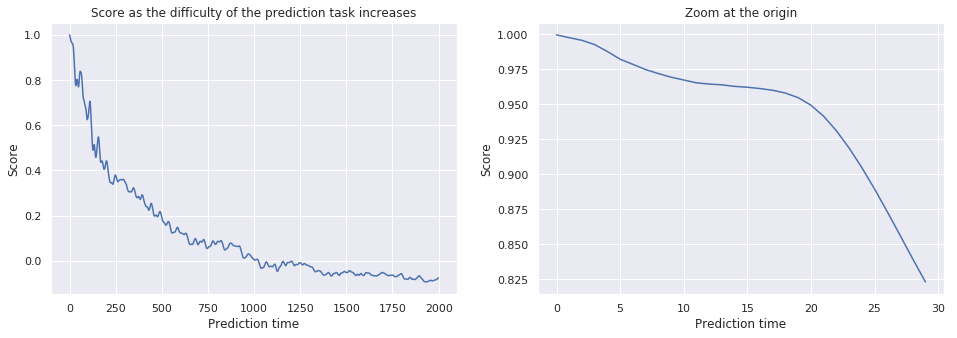

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(valid_score)
ax1.set_title('Score as the difficulty of the prediction task increases')
ax1.set_xlabel('Prediction time')
ax1.set_ylabel('Score')

ax2.plot(valid_score[:30])
ax2.set_title('Zoom at the origin')
ax2.set_xlabel('Prediction time')
ax2.set_ylabel('Score')

# Time series length needed

In [103]:
n_length = 100
length_vec = np.ceil(np.logspace(2.1, 3.5, num=n_length))
score_vec = np.zeros((n_length, ))

for i_l in range(n_length):
    length = length_vec[i_l]
    print('Current training time series length: ' + str(length))
    input_data = data1D.mackey_glass(sequence_length=int(length), n_sequence=1)
    b = Reservoir(future_pred=True, verbose=False)
    b.fit(input_data)
    
    input_data = data1D.mackey_glass(sequence_length=10000, n_sequence=1)
    pred_output, valid_score = b.score(input_data)
    
    score_vec[i_l] = np.mean(valid_score)

Current training time series length: 126.0
100%|██████████| 10000/10000 [00:00<00:00, 26210.39it/s]
Current training time series length: 131.0
100%|██████████| 10000/10000 [00:00<00:00, 27257.17it/s]
Current training time series length: 135.0
100%|██████████| 10000/10000 [00:00<00:00, 26018.82it/s]
Current training time series length: 139.0
100%|██████████| 10000/10000 [00:00<00:00, 16061.94it/s]
Current training time series length: 144.0
100%|██████████| 10000/10000 [00:00<00:00, 23806.80it/s]
Current training time series length: 149.0
100%|██████████| 10000/10000 [00:00<00:00, 25632.02it/s]
Current training time series length: 154.0
100%|██████████| 10000/10000 [00:00<00:00, 26320.37it/s]
Current training time series length: 159.0
100%|██████████| 10000/10000 [00:00<00:00, 26273.70it/s]
Current training time series length: 164.0
100%|██████████| 10000/10000 [00:00<00:00, 25376.25it/s]
Current training time series length: 169.0
100%|██████████| 10000/10000 [00:00<00:00, 26267.33it/s]


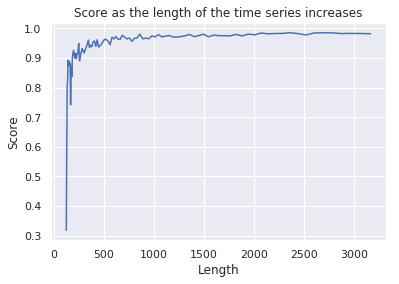

In [104]:
fig, ax = plt.subplots()
ax.plot(length_vec, score_vec)
ax.set_title('Score as the length of the time series increases')
ax.set_xlabel('Length')
ax.set_ylabel('Score');

# Effect of parallelization

In [129]:
n_par_max = 20
score_vec = np.zeros((n_par_max, ))
time_vec = np.zeros((n_par_max, ))
length = 4000

for n_par in range(1, n_par_max+1):
    print('Current parallelization number: ' + str(n_par))
    input_data = data1D.mackey_glass(sequence_length=int(length / n_par), n_sequence=n_par)
    b = Reservoir(future_pred=True, verbose=0, parallel_runs=n_par)
    b.fit(input_data)
    
    input_data = data1D.mackey_glass(sequence_length=int(length / n_par), n_sequence=n_par)
    pred_output, valid_score = b.score(input_data)
    
    score_vec[n_par-1] = np.mean(valid_score)
    time_vec[n_par-1] = b.iterate_timer

score_vec2 = np.zeros((n_par_max, ))
length = 20000
for n_par in range(1, n_par_max+1):
    print('Current parallelization number: ' + str(n_par))
    input_data = data1D.mackey_glass(sequence_length=int(length / n_par), n_sequence=n_par)
    b = Reservoir(future_pred=True, verbose=0, parallel_runs=n_par)
    b.fit(input_data)
    
    input_data = data1D.mackey_glass(sequence_length=int(length / n_par), n_sequence=n_par)
    pred_output, valid_score = b.score(input_data)
    
    score_vec2[n_par-1] = np.mean(valid_score)
    time_vec[n_par-1] = b.iterate_timer

Current parallelization number: 1
Current parallelization number: 2
Current parallelization number: 3
Current parallelization number: 4
Current parallelization number: 5
Current parallelization number: 6
Current parallelization number: 7
Current parallelization number: 8
Current parallelization number: 9
Current parallelization number: 10
Current parallelization number: 11
Current parallelization number: 12
Current parallelization number: 13
Current parallelization number: 14
Current parallelization number: 15
Current parallelization number: 16
Current parallelization number: 17
Current parallelization number: 18
Current parallelization number: 19
Current parallelization number: 20
Current parallelization number: 1
Current parallelization number: 2
Current parallelization number: 3
Current parallelization number: 4
Current parallelization number: 5
Current parallelization number: 6
Current parallelization number: 7
Current parallelization number: 8
Current parallelization number: 9
Cur

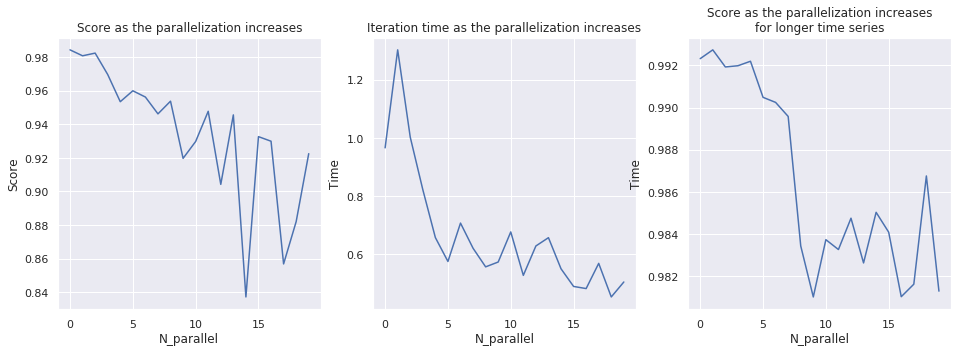

In [130]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
ax1.plot(score_vec)
ax1.set_title('Score as the parallelization increases')
ax1.set_xlabel('N_parallel')
ax1.set_ylabel('Score');
ax2.plot(time_vec)
ax2.set_title('Iteration time as the parallelization increases')
ax2.set_xlabel('N_parallel')
ax2.set_ylabel('Time');
ax3.plot(score_vec2)
ax3.set_title('Score as the parallelization increases\nfor longer time series')
ax3.set_xlabel('N_parallel')
ax3.set_ylabel('Time');

# Score for larger reservoirs

In [140]:
n_tries = 10
n_res_vec = np.ceil(np.logspace(2, 4, num=n_tries))
score_vec = np.zeros((n_tries, ))
time_vec = np.zeros((n_tries, ))

for i in range(n_tries):
    n_res = n_res_vec[i]
    print('Current neuron number: ' + str(n_res))
    input_data = data1D.mackey_glass(sequence_length=10000, n_sequence=1)
    b = Reservoir(n_res=int(n_res), future_pred=True, verbose=0)
    b.fit(input_data)
    
    input_data = data1D.mackey_glass(sequence_length=10000, n_sequence=1)
    pred_output, valid_score = b.score(input_data)
    
    score_vec[i] = np.mean(valid_score)
    time_vec[i] = b.iterate_timer

Current neuron number: 100.0
Current neuron number: 167.0
Current neuron number: 279.0
Current neuron number: 465.0
Current neuron number: 775.0
Current neuron number: 1292.0
Current neuron number: 2155.0
Current neuron number: 3594.0
Current neuron number: 5995.0
Current neuron number: 10000.0


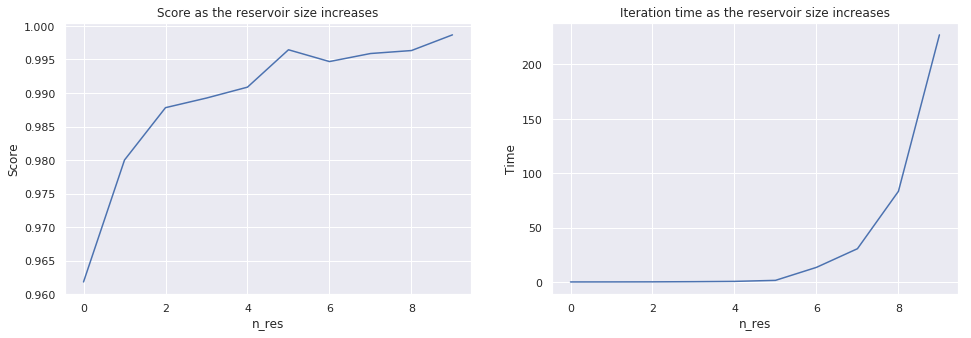

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.plot(score_vec)
ax1.set_title('Score as the reservoir size increases')
ax1.set_xlabel('n_res')
ax1.set_ylabel('Score');
ax2.plot(time_vec)
ax2.set_title('Iteration time as the reservoir size increases')
ax2.set_xlabel('n_res')
ax2.set_ylabel('Time');

# Recursive prediction test

In [297]:
pred_horizon = 10
rec_pred_steps = 100

input_data = data1D.mackey_glass(sequence_length=10000, n_sequence=1)
b = Reservoir(n_res=10000,future_pred=True, pred_horizon=pred_horizon, rec_pred_steps=rec_pred_steps, train_param=2e1)
b.fit(input_data)

init_length = 2000
input_data = data1D.mackey_glass(sequence_length=init_length+pred_horizon*rec_pred_steps)
pred_output = b.recursive_predict(input_data[:,:init_length,:])

Start of training...
Initialization finished. Elapsed time: 3.2683894634246826s
100%|██████████| 10000/10000 [03:50<00:00, 43.39it/s]
Iterations finished. Elapsed time: 230.46140718460083s
Training finished. Elapsed time: 12.009397506713867s
Training score: 0.9966796802926476
Start of testing...
Initialization finished. Elapsed time:
0.0006911754608154297
100%|██████████| 2000/2000 [00:45<00:00, 43.94it/s]
Iterations finished. Elapsed time:
45.521809339523315
[-0.02670443 -0.03965172 -0.05286733 -0.0697406  -0.09343163]
[-0.12567672 -0.16460998 -0.20652854 -0.24689997 -0.28182398]
[[-0.12567672 -0.16460998 -0.20652854 -0.24689997 -0.28182398 -0.30836849
  -0.32458515 -0.32952896 -0.32322128 -0.30673804]]
100%|██████████| 10/10 [00:00<00:00, 45.32it/s]
Testing finished. Elapsed time:
22.517258167266846


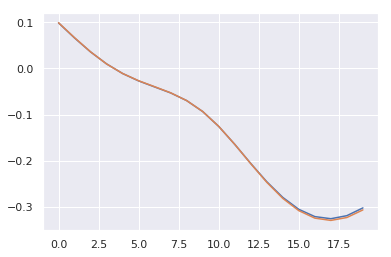

In [298]:
plt.plot(np.squeeze(input_data[0,-1010:-990,0]))
plt.plot(np.squeeze(pred_output[0,-1010:-990,0]));

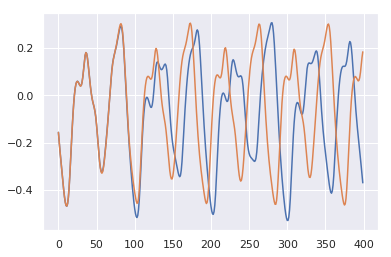

In [301]:
plt.plot(np.squeeze(input_data[0,-1050:-650,0]))
plt.plot(np.squeeze(pred_output[0,-1050:-650,0]));